In [1]:
import numpy as np
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    

import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator  
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.schedules import ExponentialDecay

In [2]:
# Importing dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import numpy as np
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt

# Create an ImageDataGenerator for rescaling and grayscale conversion
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,

)

# Set the target size to 31 by 31 pixels
target_size = (128, 128)

train_set = train_datagen.flow_from_directory(
    'Dataset for CA1 part A/train/',
    target_size=target_size,
    batch_size=9028,
    class_mode='categorical',
    color_mode='grayscale'  # Ensure grayscale color mode
)

test_set = train_datagen.flow_from_directory(
    'Dataset for CA1 part A/test/',
    target_size=target_size,
    batch_size=3000,
    class_mode='categorical',
    color_mode='grayscale'
)

val_set = train_datagen.flow_from_directory(
    'Dataset for CA1 part A/validation/',
    target_size=target_size,
    batch_size=3000,
    class_mode='categorical',
    color_mode='grayscale'
)



Found 9028 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [3]:
# Train,test,val
import cv2
X_train, y_train = train_set.next()
X_test, y_test = test_set.next()
X_val, y_val = val_set.next()

seed = 1
np.random.seed(seed)
num_classes = y_test.shape[1]

In [4]:
# Dealing with class imbalance
from sklearn.utils.class_weight import compute_class_weight

actual_class_labels_train = train_set.classes

# Calculate class weights for the training set
class_labels_train = np.unique(actual_class_labels_train)
class_weights_train = compute_class_weight(class_weight='balanced', classes=class_labels_train, y=actual_class_labels_train)

# Convert class weights to a dictionary
class_weight_dict_train = dict(zip(class_labels_train, class_weights_train))
print(class_weight_dict_train)

{0: 0.7716239316239316, 1: 0.835925925925926, 2: 1.3647770219198792, 3: 0.693394777265745, 4: 0.8024888888888889, 5: 1.1965540092776674, 6: 1.7147198480531813, 7: 2.3510416666666667, 8: 1.0253265190232823, 9: 0.7412151067323481, 10: 1.0633686690223794, 11: 1.5964633068081344, 12: 0.7393939393939394, 13: 2.4268817204301074, 14: 0.6302268760907505}


In [5]:
# Model training
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
tf.keras.backend.clear_session()
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
lr_scheduler = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_rate = 0.8,
    decay_steps = 700)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_scheduler), metrics=['accuracy'])

In [6]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
model_save = ModelCheckpoint('model128_1.h5', save_best_only=True, save_weights_only=True)
h_callback= model.fit(X_train,y_train,epochs=100, validation_data=(X_val, y_val),class_weight=class_weight_dict_train,#,
         callbacks = [model_save,early_stopping])

Epoch 1/100
283/283 [==============================] - 7s 18ms/step - loss: 2.3260 - accuracy: 0.2412 - val_loss: 2.1155 - val_accuracy: 0.3190
Epoch 2/100
283/283 [==============================] - 5s 17ms/step - loss: 1.5064 - accuracy: 0.5228 - val_loss: 1.5004 - val_accuracy: 0.5300
Epoch 3/100
283/283 [==============================] - 5s 17ms/step - loss: 1.0122 - accuracy: 0.6852 - val_loss: 1.1600 - val_accuracy: 0.6400
Epoch 4/100
283/283 [==============================] - 5s 17ms/step - loss: 0.7313 - accuracy: 0.7734 - val_loss: 1.1408 - val_accuracy: 0.6353
Epoch 5/100
283/283 [==============================] - 5s 16ms/step - loss: 0.5393 - accuracy: 0.8251 - val_loss: 0.8462 - val_accuracy: 0.7407
Epoch 6/100
283/283 [==============================] - 5s 18ms/step - loss: 0.4065 - accuracy: 0.8706 - val_loss: 0.8432 - val_accuracy: 0.7493
Epoch 7/100
283/283 [==============================] - 5s 17ms/step - loss: 0.2875 - accuracy: 0.9051 - val_loss: 0.7899 - val_accuracy:

In [7]:
# Functions
def plot_loss(loss,val_loss):
    plt.figure()
    plt.plot(loss)
    plt.plot(val_loss)
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train','Test'],loc='upper right')
    plt.show()
    
def plot_acc(acc,val_acc):
    plt.figure()
    plt.plot(acc)
    plt.plot(val_acc)
    plt.show()

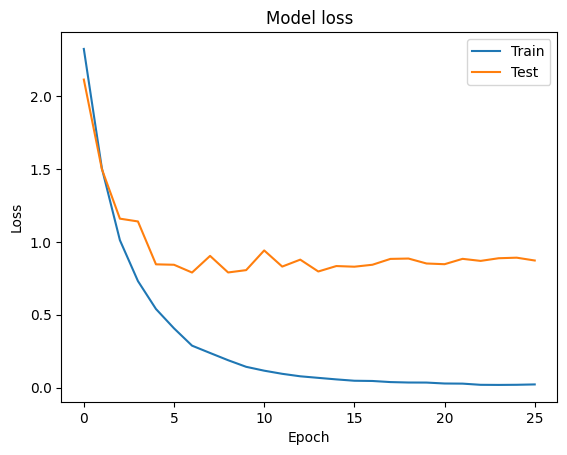

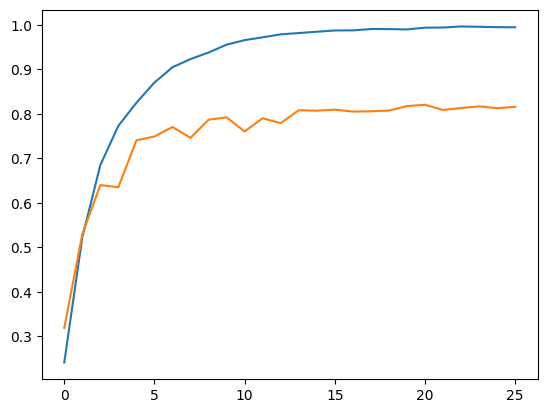

In [8]:
plot_loss(h_callback.history['loss'],h_callback.history['val_loss'])
plot_acc(h_callback.history['accuracy'],h_callback.history['val_accuracy'])

In [9]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 17.83%


In [12]:
model = Sequential()



model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3), activation='relu'))  # Added Conv2D layer
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.3))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))
lr_scheduler = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_rate = 0.8,
    decay_steps = 1000)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_scheduler), metrics=['accuracy'])

In [13]:
model_save = ModelCheckpoint('model128_2.h5', save_best_only=True, save_weights_only=True)
h_callback= model.fit(X_train,y_train,epochs=100, validation_data=(X_val, y_val),class_weight=class_weight_dict_train,#,
         callbacks = [model_save,early_stopping])

Epoch 1/100
283/283 [==============================] - 10s 33ms/step - loss: 2.5993 - accuracy: 0.1427 - val_loss: 2.1622 - val_accuracy: 0.3317
Epoch 2/100
283/283 [==============================] - 9s 31ms/step - loss: 2.1249 - accuracy: 0.3104 - val_loss: 1.7942 - val_accuracy: 0.4540
Epoch 3/100
283/283 [==============================] - 9s 33ms/step - loss: 1.7967 - accuracy: 0.4310 - val_loss: 1.5893 - val_accuracy: 0.5070
Epoch 4/100
283/283 [==============================] - 9s 32ms/step - loss: 1.5029 - accuracy: 0.5301 - val_loss: 1.2436 - val_accuracy: 0.6143
Epoch 5/100
283/283 [==============================] - 9s 32ms/step - loss: 1.2093 - accuracy: 0.6196 - val_loss: 1.0399 - val_accuracy: 0.6783
Epoch 6/100
283/283 [==============================] - 9s 32ms/step - loss: 1.0008 - accuracy: 0.6802 - val_loss: 0.9879 - val_accuracy: 0.7067
Epoch 7/100
283/283 [==============================] - 9s 32ms/step - loss: 0.8092 - accuracy: 0.7381 - val_loss: 0.8675 - val_accuracy

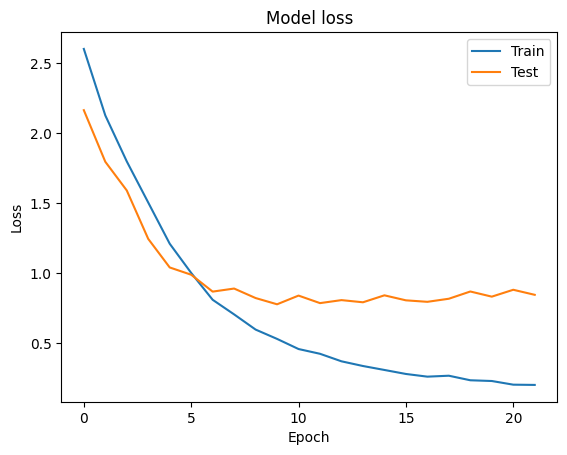

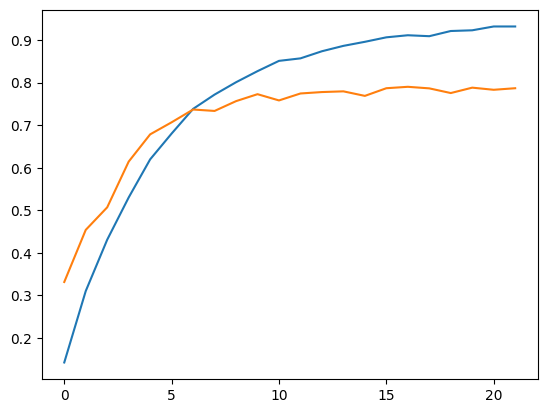

In [14]:
plot_loss(h_callback.history['loss'],h_callback.history['val_loss'])
plot_acc(h_callback.history['accuracy'],h_callback.history['val_accuracy'])

In [15]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 20.47%


In [24]:
model = Sequential()

model.add(Conv2D(32, (3, 3), input_shape=(128, 128, 1), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(50, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

lr_scheduler = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_rate=0.8,
    decay_steps=700)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_scheduler), metrics=['accuracy'])

In [25]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
model_save = ModelCheckpoint('model128_5.h5', save_best_only=True, save_weights_only=True)
h_callback= model.fit(X_train,y_train,epochs=100, validation_data=(X_val, y_val),class_weight=class_weight_dict_train,#,
         callbacks = [model_save,early_stopping])

Epoch 1/100
283/283 [==============================] - 7s 24ms/step - loss: 1.6269 - accuracy: 0.4855 - val_loss: 25.6893 - val_accuracy: 0.0667
Epoch 2/100
283/283 [==============================] - 7s 23ms/step - loss: 0.8485 - accuracy: 0.7408 - val_loss: 11.9774 - val_accuracy: 0.1160
Epoch 3/100
283/283 [==============================] - 6s 22ms/step - loss: 0.4677 - accuracy: 0.8593 - val_loss: 2.1706 - val_accuracy: 0.4717
Epoch 4/100
283/283 [==============================] - 6s 22ms/step - loss: 0.2973 - accuracy: 0.9138 - val_loss: 4.6997 - val_accuracy: 0.2707
Epoch 5/100
283/283 [==============================] - 7s 23ms/step - loss: 0.1954 - accuracy: 0.9442 - val_loss: 1.4905 - val_accuracy: 0.6013
Epoch 6/100
283/283 [==============================] - 7s 23ms/step - loss: 0.1187 - accuracy: 0.9661 - val_loss: 0.8528 - val_accuracy: 0.7430
Epoch 7/100
283/283 [==============================] - 6s 22ms/step - loss: 0.0885 - accuracy: 0.9775 - val_loss: 0.9451 - val_accurac

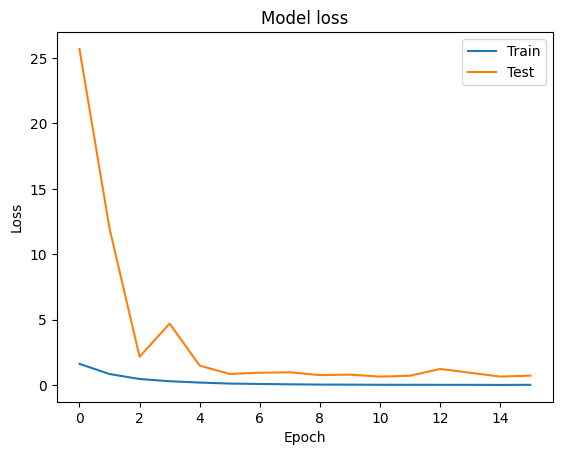

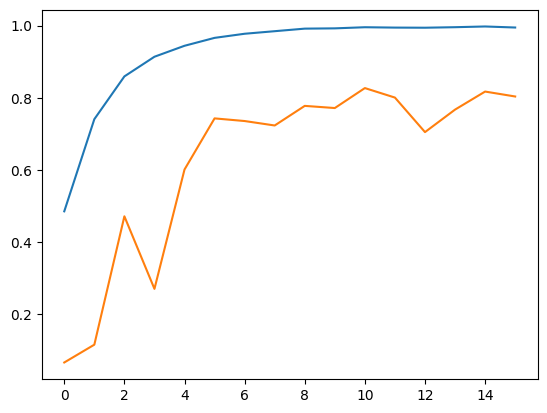

In [26]:
plot_loss(h_callback.history['loss'],h_callback.history['val_loss'])
plot_acc(h_callback.history['accuracy'],h_callback.history['val_accuracy'])

In [27]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 19.27%


In [28]:
model =Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Dropout(0.35))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.35))
model.add(Dense(num_classes, activation='softmax'))
lr_scheduler = ExponentialDecay(
    initial_learning_rate = 0.001,
    decay_rate = 0.8,
    decay_steps = 1000)
model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=lr_scheduler), metrics=['accuracy'])

In [29]:
early_stopping = EarlyStopping(monitor='val_accuracy', patience = 5)
model_save = ModelCheckpoint('model128_2.h5', save_best_only=True, save_weights_only=True)
h_callback= model.fit(X_train,y_train,epochs=100, validation_data=(X_val, y_val),class_weight=class_weight_dict_train,#,
         callbacks = [model_save,early_stopping])

Epoch 1/100
283/283 [==============================] - 5s 18ms/step - loss: 2.6384 - accuracy: 0.1093 - val_loss: 2.4374 - val_accuracy: 0.2093
Epoch 2/100
283/283 [==============================] - 5s 19ms/step - loss: 2.2079 - accuracy: 0.2432 - val_loss: 2.0048 - val_accuracy: 0.3847
Epoch 3/100
283/283 [==============================] - 5s 18ms/step - loss: 1.8722 - accuracy: 0.3811 - val_loss: 1.4931 - val_accuracy: 0.5400
Epoch 4/100
283/283 [==============================] - 5s 18ms/step - loss: 1.5627 - accuracy: 0.4961 - val_loss: 1.3710 - val_accuracy: 0.5700
Epoch 5/100
283/283 [==============================] - 5s 17ms/step - loss: 1.3118 - accuracy: 0.5847 - val_loss: 0.9843 - val_accuracy: 0.7137
Epoch 6/100
283/283 [==============================] - 5s 17ms/step - loss: 1.0835 - accuracy: 0.6486 - val_loss: 0.7980 - val_accuracy: 0.7647
Epoch 7/100
283/283 [==============================] - 5s 17ms/step - loss: 0.9251 - accuracy: 0.6982 - val_loss: 0.6918 - val_accuracy:

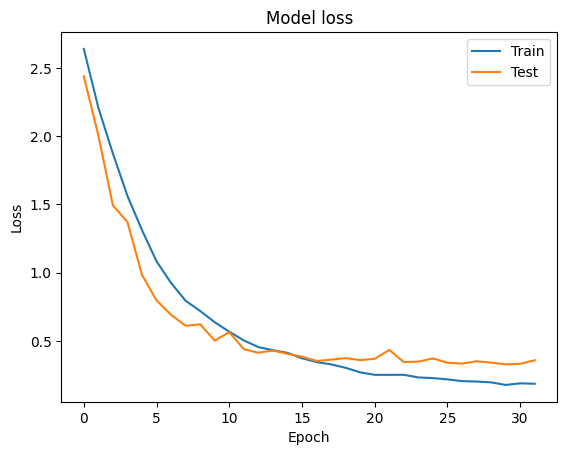

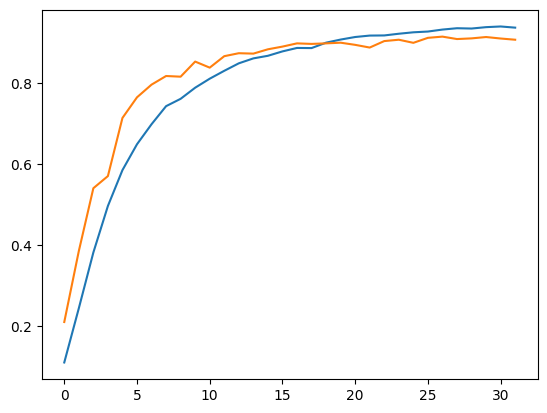

In [30]:
plot_loss(h_callback.history['loss'],h_callback.history['val_loss'])
plot_acc(h_callback.history['accuracy'],h_callback.history['val_accuracy'])

In [31]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("CNN Error: %.2f%%" % (100-scores[1]*100))

CNN Error: 9.07%


In [32]:
# Classification report
from sklearn.metrics import classification_report
y_pred = model.predict(X_val)

# Convert one-hot encoded predictions to class labels (if needed)
y_pred_classes = np.argmax(y_pred, axis=1)

# Assuming y_val is one-hot encoded, you might want to convert it to class labels as well
y_val_classes = np.argmax(y_val, axis=1)

# Generate a classification report
print(classification_report(y_val_classes, y_pred_classes))

94/94 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.93      0.93      0.93       200
           1       0.96      0.98      0.97       200
           2       0.96      0.93      0.94       200
           3       0.86      0.88      0.87       200
           4       0.97      0.93      0.95       200
           5       0.88      0.82      0.85       200
           6       0.87      0.91      0.89       200
           7       0.87      0.94      0.90       200
           8       0.88      0.93      0.90       200
           9       0.93      0.95      0.94       200
          10       0.90      0.89      0.89       200
          11       0.86      0.91      0.88       200
          12       0.91      0.91      0.91       200
          13       0.95      0.81      0.87       200
          14       0.89      0.91      0.90       200

    accuracy                           0.91      3000
   macro avg       0.91    